In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import load_data
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
import plot_learning_curve
from sklearn.model_selection import ShuffleSplit
from matplotlib import cm
import importlib
import cdms2 as cdms
import MV2 as MV
from sklearn.preprocessing import MinMaxScaler
import xlrd

In [2]:
sites = ['sgp','goamazon']
feature_path = "/global/homes/z/zhangtao/ML_trigger/ML/data/"
feature_files = ["Arm_CF_1999_2009_hy.nc"]
cape_names = ['dilute_dcape','dilute_cape','undilute_dcape','undilute_cape']
cape_names_sh = ['dd','dc','udd','udc']
scam_dir="/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/"

In [3]:
def load_ArmData(path):
    fid = cdms.open(path)
    prect = fid('prec_srf')
    q = fid('q')
    T = fid('T')
    u = fid('u')
    v = fid('v')
    q_adv_h = fid('q_adv_h')
    s_adv_h = fid('s_adv_h')
    LH = fid('LH')
    SH = fid('SH')
    RH_srf = fid('RH_srf')
    T_srf = fid('T_srf')
    
    # lower (700–800hPa), upper (200–300hPa),middle(300–700 hPa)    600hpa  
    #Chen Q, et al. Roles of wind shear at different vertical levels: Cloud 
    #system organization and properties.
    
    #vertical wind shear
    u_low = u[:,8] #800hpa
    u_mid = u[:,12] #700hpa
    u_high = u[:,28] # 300hpa
    u_top = u[:,32] # 200hpa
    
    v_low = v[:,8] #800hpa
    v_mid = v[:,12] #700hpa
    v_high = v[:,28] # 300hpa
    v_top = v[:,32] # 200hpa
    
    u_shear_low = u_mid - u_low
    u_shear_mid = u_high - u_mid
    u_shear_high = u_top - u_high
    
    v_shear_low = v_mid - v_low
    v_shear_mid = v_high - v_mid
    v_shear_high = v_top - v_high
    
    shear_low = (u_shear_low**2 + v_shear_low**2)**0.5
    shear_mid = ( u_shear_mid**2 + v_shear_mid**2 )**0.5
    shear_high = ( u_shear_high**2 + v_shear_high**2 )**0.5
    
    #shear_low = u_shear_low + v_shear_low 
    #shear_mid = u_shear_mid + v_shear_mid
    #shear_high = u_shear_high + v_shear_high
    
    #T and Q average
    T_low = MV.average(T[:,8:12+1],axis=1) #800hpa - 700hpa
    T_mid = MV.average(T[:,12:28+1],axis=1) #700hpa - 300hpa
    T_high = MV.average(T[:,28:32+1],axis=1) # 300hpa - 200hpa
    
    q_low = MV.average(q[:,8:12+1],axis=1) 
    q_mid = MV.average(q[:,12:28+1],axis=1) 
    q_high = MV.average(q[:,28:32+1],axis=1) 
    
    #Advective Tendency average
    q_adv_h_low = MV.average(q_adv_h[:,8:12+1],axis=1) 
    q_adv_h_mid = MV.average(q_adv_h[:,12:28+1],axis=1) 
    q_adv_h_high = MV.average(q_adv_h[:,28:32+1],axis=1) 
    
    s_adv_h_low = MV.average(s_adv_h[:,8:12+1],axis=1) 
    s_adv_h_mid = MV.average(s_adv_h[:,12:28+1],axis=1) 
    s_adv_h_high = MV.average(s_adv_h[:,28:32+1],axis=1)  
    
    #single level variable
    
    dataset = pd.DataFrame()
    
    dataset['LH'] = LH
    dataset['SH'] = SH
    dataset['RH_srf'] = RH_srf
    dataset['T_srf'] = T_srf
    
    dataset['shear_low'] = v_shear_low
    dataset['shear_mid'] = v_shear_mid
    dataset['shear_high'] = v_shear_high
    dataset['T_low'] = T_low
    dataset['T_mid'] = T_mid
    dataset['T_high'] = T_high
    dataset['q_low'] = q_low
    dataset['q_mid'] = q_mid
    dataset['q_high'] = q_high
    dataset['q_adv_h_low'] = q_adv_h_low
    dataset['q_adv_h_mid'] = q_adv_h_mid
    dataset['q_adv_h_high'] = q_adv_h_high
    dataset['s_adv_h_low'] = s_adv_h_low
    dataset['s_adv_h_mid'] = s_adv_h_mid
    dataset['s_adv_h_high'] = s_adv_h_high
    
    dataset['prect'] = prect
    
    #dataset['trigger'] = np.where(prect > 0.5,1,0)
    #print(q.getAxis(1))
    #print(q.getAxis(1)[:])
    #print(prect.shape)
    #print(q.shape)
    
    return dataset
    
#load_ArmData(feature_path+"Arm_CF_1999_2009.nc")

In [4]:
dataset_all = {}
dataset_train_all = {}
dataset_test_all = {}

# load data

In [5]:
# read features

for site in sites:
    # load 4 cape triggers
    cape4s = {}
    for cape,cape_sh in zip(cape_names,cape_names_sh):
        cape4s[cape_sh] = np.loadtxt(scam_dir+site+"_"+cape+"_tiedke_0.5.txt")
        
    if site == 'sgp':
        dataset = load_ArmData(feature_path+"Arm_CF_1999_2009.nc")
    elif site == 'goamazon':
        dataset = load_ArmData(feature_path+"goamazon_2014_2015.nc")

    cin = np.loadtxt(feature_path+"cin_"+site+".txt")
    dataset['cin'] = cin
    dataset['ddcape'] = cape4s['dd']
    dataset['trigger'] = np.where(dataset.loc[:,'prect']>=0.5, 1, 0)
    prect = dataset.loc[:,'prect']

    dataset.drop(columns='prect',inplace=True)
    dataset['prect'] = prect

    #dataset[['prect','ddcape']] = dataset[['ddcape','prect']]
    #dataset.rename(columns={'prect':'cape'}, inplace=True)
    #dataset.rename(columns={'ddcape':'prect'}, inplace=True)

    #if site == 'sgp':
    #    dataset = dataset.iloc[::3,:]
    
    dataset_all[site] = dataset

In [78]:
dataset_all['sgp'].iloc[:,:23].head()

,LH,SH,RH_srf,T_srf,shear_low,shear_mid,shear_high,T_low,T_mid,T_high,...,q_adv_h_low,q_adv_h_mid,q_adv_h_high,s_adv_h_low,s_adv_h_mid,s_adv_h_high,cin,ddcape,trigger,prect
0,75.466141,7.962654,67.626862,26.569201,-2.53340,-0.439800,2.277530,287.479797,261.649536,227.376801,...,0.270640,0.071648,0.009683,0.236668,-0.101891,0.104103,-180.257112,118.7672,0,0.052067
1,24.207590,-0.258206,73.269478,25.152603,-2.60500,0.710010,2.058910,287.409790,261.649170,227.656403,...,0.398010,0.101111,0.010599,0.235860,-0.095660,0.156116,-158.939301,187.9128,0,0.436567
2,2.120878,1.778930,78.389183,23.797127,-2.65099,2.490150,1.903800,287.400818,261.629364,227.907013,...,0.502686,0.106643,0.007882,0.260052,-0.115239,0.182571,-144.168442,267.2368,1,0.969400
3,-2.306376,12.764638,81.118980,22.754717,-2.54720,3.758360,2.322770,287.463379,261.557800,227.999420,...,0.475903,0.076626,0.001051,0.215509,-0.275333,0.026891,-140.555413,391.7533,1,1.625967
4,-13.743360,21.948606,82.284218,21.948774,-2.37520,3.851871,3.096439,287.494995,261.392853,227.882416,...,0.331158,0.023585,-0.008498,0.184140,-0.408048,-0.180879,-139.208250,432.5973,1,1.869100


# verify cape value

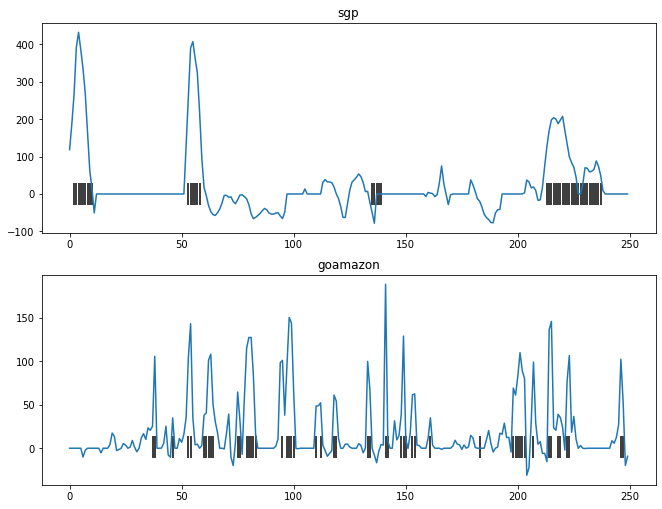

In [71]:
fig,axes = plt.subplots(2,1,figsize=(11,8.5),squeeze=False)

for n,site in enumerate(sites):
    dataset = dataset_all[site]
    n_sample = dataset.shape[0]
    real_trigger = np.zeros(n_sample)
    
    for i in range(n_sample):
        if dataset.loc[i,'prect'] > 0.5:
            real_trigger[i] = 1
        else:
            real_trigger[i] = np.nan
            
    axes[n][0].scatter(range(250),real_trigger[:250], color='k',marker='|',s=500)
    axes[n][0].plot(range(250), dataset.loc[:250-1,'ddcape'])
    axes[n][0].set_title(site)

# divide training and testing data

In [6]:
for site in sites:
    dataset_x = dataset_all[site].iloc[:,:21+1]
    dataset_y = dataset_all[site].iloc[:,21]
    
    #scaler = MinMaxScaler()
    #dataset_x = pd.DataFrame(scaler.fit_transform(dataset_x),columns=dataset_x.columns)
    
    dataset_x_train, dataset_x_test, dataset_y_train, dataset_y_test=train_test_split(
        dataset_x, dataset_y, test_size=0.2, random_state=20)
    
    dataset_train_all[site] = dataset_x_train
    dataset_test_all[site] = dataset_x_test

# performance of cape triggers

In [80]:
cape_thres = 65

for site in sites:
    print(site)
    
    dataset_test = dataset_test_all[site]
    real_trigger = dataset_test_all[site].iloc[:,21]
    
    n_test = dataset_test.shape[0]
    
    cape_trigger = np.zeros(n_test)
    for i in range(n_test):
        if dataset_test.iloc[i,20] > cape_thres:
            cape_trigger[i] = 1
            
    tn, fp, fn, tp = confusion_matrix(real_trigger, cape_trigger).ravel()
    f1 = f1_score(real_trigger, cape_trigger,average='macro')
    p  = precision_score(real_trigger, cape_trigger,average='macro')
    r  = recall_score(real_trigger, cape_trigger,average='macro')

    print(tp,fp,fn,tn)
    print(f1, p, r)
    

sgp
250 136 172 4002
0.7908785103726927 0.8032304594690547 0.779775471356678
goamazon
116 1 81 970
0.8491497980809819 0.9571917668968097 0.7939013105961199


# performance of xgb trigger

sgp
336 46 86 4092
0.9099739398246862 0.9294985701718551 0.8925460247068552
goamazon
166 14 31 957
0.9288328506261654 0.9454228520017993 0.9141107341324816


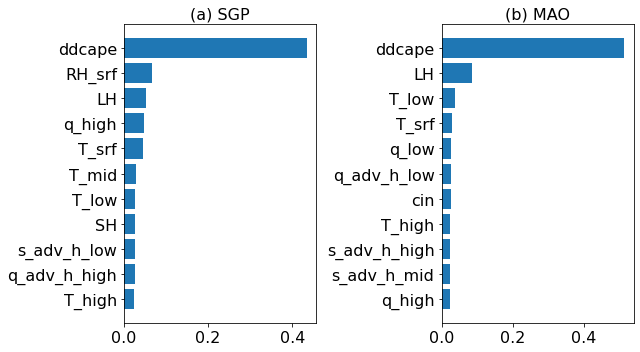

In [81]:
fig, axes = plt.subplots(1,2,figsize=(9,5), squeeze=False)
titles = ["(a) SGP", "(b) MAO"]
fh = 16

for n,site in enumerate(sites):
    dataset_train_x = dataset_train_all[site].iloc[:,:21]
    dataset_train_y = dataset_train_all[site].iloc[:,21]
    
    dataset_test_x = dataset_test_all[site].iloc[:,:21]
    dataset_test_y = dataset_test_all[site].iloc[:,21]
    
    xgb = XGBClassifier(n_estimators=600, nthread=20, max_depth=7,scale_pos_weight=3.5)
    xgb.fit(dataset_train_x, dataset_train_y)
    
    data_predic_y = xgb.predict(dataset_test_x)
    
    tn, fp, fn, tp = confusion_matrix(dataset_test_y, data_predic_y).ravel()
    f1 = f1_score(dataset_test_y, data_predic_y, average='macro')
    p  = precision_score(dataset_test_y, data_predic_y, average='macro')
    r  = recall_score(dataset_test_y, data_predic_y, average='macro')

    print(site)
    print(tp,fp,fn,tn)
    print(f1,p,r)
    
    #display importance
    importance = xgb.feature_importances_
    name = dataset_all[site].columns.values.tolist()[:21]
    imp = pd.DataFrame({"imp":importance, "name":name})
    imp.sort_values('imp',inplace=True,ascending=False)
    imp.reset_index(inplace=True)
    axes[0][n].invert_yaxis()
    axes[0][n].barh(imp.loc[:10,'name'],imp.loc[:10,'imp'])
    axes[0][n].set_title(titles[n],fontsize=fh)
    axes[0][n].tick_params(labelsize=fh)
    
plt.tight_layout()
plt.savefig("figs/imp.pdf")

# XGB learning curve

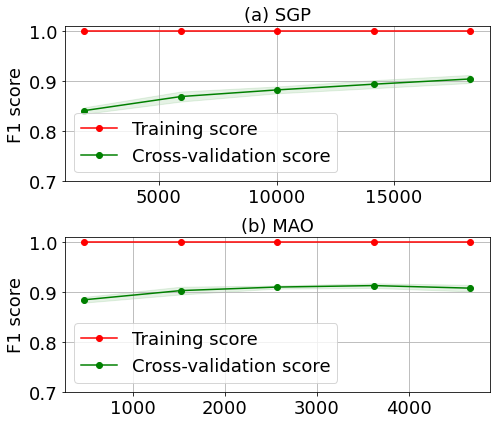

In [13]:
importlib.reload(plot_learning_curve)

fh = 18
titles = ['(a) SGP','(b) MAO']
fig, axes = plt.subplots(2,1,figsize=(7,6),squeeze=False)

for n,site in enumerate(sites):

    dataset_x = dataset_all[site].iloc[:,:21]
    dataset_y = dataset_all[site].iloc[:,21]

    xgb = XGBClassifier(n_estimators=600,silent=True, nthread=10, max_depth=7,scale_pos_weight=3.5)
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
    ax = plot_learning_curve.plot_learning_curve(axes[n][0],xgb,dataset_x, dataset_y, ylim=(0.7, 1.01), cv=cv, n_jobs=20)

    axes[n][0].set_xlabel("")
    axes[n][0].tick_params(labelsize=fh)
    axes[n][0].set_title(titles[n], fontsize=fh)
    axes[n][0].set_ylabel('F1 score', fontsize=fh)
    axes[n][0].legend(fontsize=fh)
    axes[n][0].legend(fontsize=fh, loc='lower left')
    
plt.tight_layout()

# performance compare

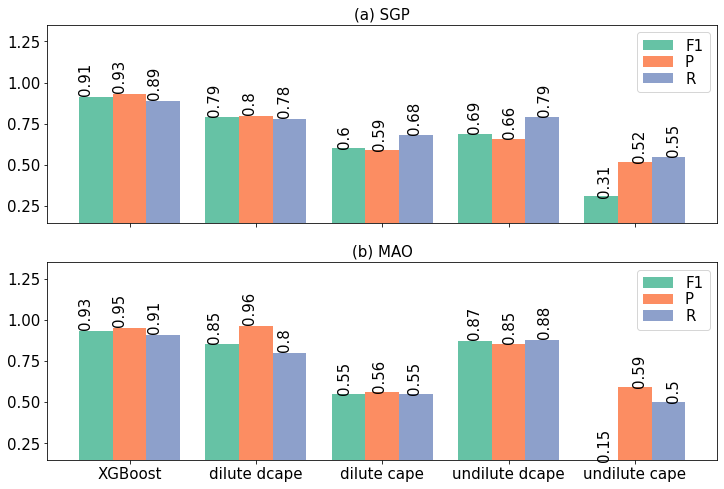

In [160]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,8))
fh = 15
sites = ["SGP", "MAO"]

palette = plt.get_cmap('Set2')

for site,n in zip(sites, range(2)):
    #perf = pd.read_excel("dmpdz.xlsx", sheet_name=site, index_col='name')
    perf = pd.read_excel("cmp_triggers_layer_average.xlsx", sheet_name=site, index_col='name',engine='openpyxl').iloc[:5,:]
    perf.iloc[:,4:].plot.bar(ax=axes[n], width = .8, color=[palette(0),palette(1),palette(2)])
    axes[n].set_title(titles[n], fontsize=fh)
    axes[n].legend(loc=1,fontsize=fh,labelspacing=0.1)
    axes[n].set_ylim(0.15,1.35)
    
    for p in axes[n].patches:
        axes[n].annotate(str(p.get_height()), (p.get_x() * 1.028, p.get_height() * 1.028), rotation=90, size=fh)
        
    axes[n].tick_params(labelsize=fh)
    
plt.xlabel("")
plt.xticks(rotation=0)
plt.savefig("figs/perf.pdf")

# MLER

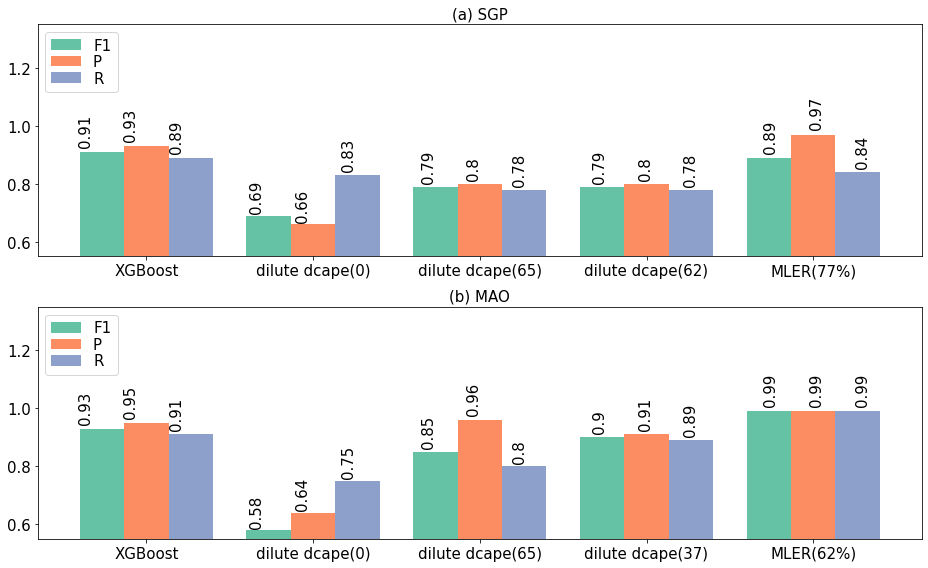

In [158]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,8))
fh = 15
sites = ["SGP_dt", "MAO_dt"]
titles = ["(a) SGP", "(b) MAO"]

palette = plt.get_cmap('Set2')

for site,n in zip(sites, range(2)):
    perf = pd.read_excel("cmp_triggers_layer_average.xlsx", sheet_name=site, index_col='name',engine='openpyxl')
    perf = perf.dropna()
    perf.iloc[:,4:].plot.bar(ax=axes[n], width = .8, color=[palette(0),palette(1),palette(2)])
    axes[n].set_title(titles[n], fontsize=fh)
    axes[n].legend(loc=2,fontsize=fh,labelspacing=0.1)
    axes[n].set_ylim(0.55,1.35)
    axes[n].tick_params(axis='x', rotation=0)
    axes[n].set_xlabel("")

    for p in axes[n].patches:
        axes[n].annotate(str(p.get_height()), (p.get_x() * 1.028, p.get_height() * 1.028), rotation=90, size=fh)
        
    axes[n].tick_params(labelsize=fh)
    
plt.tight_layout()
#plt.xticks(rotation=0)
plt.savefig("figs/perf_dt.pdf")

# Time series and diurnal cycle

(22800, 23)
prect (5688,)
(5840, 23)
prect (1448,)


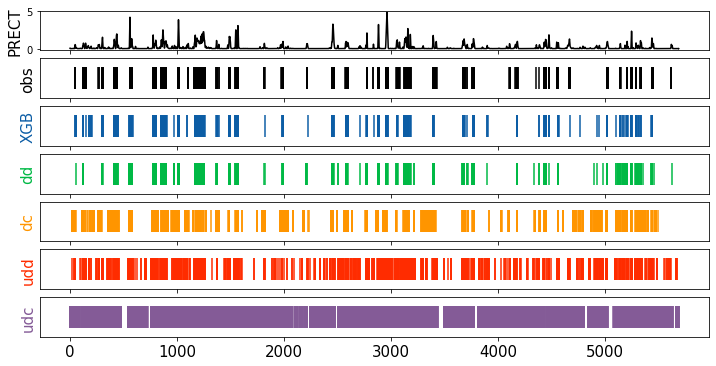

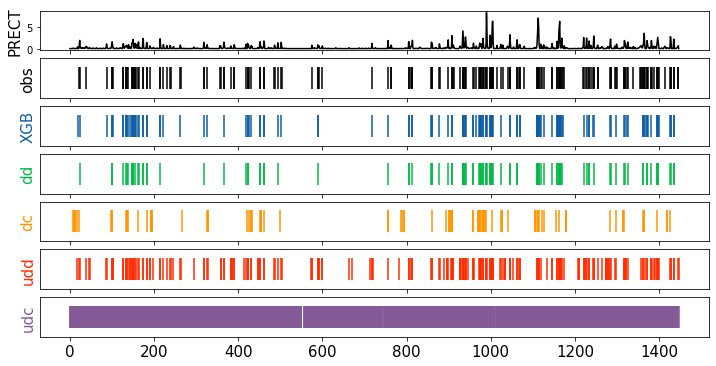

In [106]:
sites = ['sgp','goamazon']
colors=['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']
trigger_all = {}

#sites = ['sgp']
fh = 15
for site in sites:
    trigger_site = {}
    
    dataset = dataset_all[site]
    print(dataset.shape)
    
    n_all = dataset.shape[0]
    n_train = int(n_all * 3 / 4) + 12
    n_test = n_all - n_train
    
    train_x = np.array(dataset.iloc[:n_train,:21])
    train_y = np.array(dataset.iloc[:n_train,21])
    test_x = np.array(dataset.iloc[n_train:,:21])
    test_y = np.array(dataset.iloc[n_train:,21])
    prect = np.array(dataset.iloc[n_train:,22])
    trig_idx = range(n_test)
    
    print("prect",prect.shape)
    
    # machine learning predicton
    xgb = XGBClassifier(n_estimators=600, nthread=10, max_depth=7,scale_pos_weight=3.5)
    xgb.fit(train_x, train_y)
    pred_y = xgb.predict(test_x)
    
    pred_y = np.where(pred_y == 0, np.nan, pred_y)
    test_y = np.where(test_y == 0, np.nan, test_y)
    #print(test_y.shape)
        
    #cape trigger prediction
    cape4s = {}
    cape_triggers = {}
    for cape,cape_sh in zip(cape_names,cape_names_sh):
        cape4s[cape_sh] = np.loadtxt(scam_dir+site+"_"+cape+"_tiedke_0.5.txt")[n_train:]
        cape_triggers[cape_sh] = np.where(cape4s[cape_sh] > 65, 1.0, np.nan)
    
    #print(cape4s['dd'].shape)
    
    trigger_site['OBS'] = test_y
    trigger_site['XGB'] = pred_y
    for cape_sh in cape_names_sh:
        trigger_site[cape_sh] = cape_triggers[cape_sh]
        
    trigger_all[site] = trigger_site
    
    fig, axes = plt.subplots(nrows=7, ncols=1, sharex=True, figsize=(12,6))
    axes[0].plot(prect,color='k')
    axes[0].set_ylabel('PRECT',fontsize=fh)
    axes[1].scatter(trig_idx, test_y, color='k', marker='|',s=500)
    axes[1].set_ylabel('obs',fontsize=fh)
    axes[1].set_yticks([])
    axes[2].scatter(trig_idx,pred_y,color=colors[0], marker='|',s=500)
    axes[2].set_ylabel('XGB',color=colors[0],fontsize=fh)
    axes[2].set_yticks([])
    axes[3].scatter(trig_idx,cape_triggers['dd'],color=colors[1], marker='|',s=500)
    axes[3].set_ylabel('dd',color=colors[1],fontsize=fh)
    axes[3].set_yticks([])
    axes[4].scatter(trig_idx,cape_triggers['dc'], color=colors[2], marker='|',s=500)
    axes[4].set_ylabel('dc',color=colors[2],fontsize=fh)
    axes[4].set_yticks([])
    axes[5].scatter(trig_idx,cape_triggers['udd'],color=colors[3], marker='|',s=500)
    axes[5].set_ylabel('udd',color=colors[3],fontsize=fh)
    axes[5].set_yticks([])
    axes[6].scatter(trig_idx,cape_triggers['udc'],color=colors[4], marker='|',s=500)
    axes[6].set_ylabel('udc',color=colors[4],fontsize=fh)
    axes[6].set_yticks([])
    
    plt.tick_params(labelsize=fh)
    

# diurnal cycle

In [144]:
diurnal_list = ['XGB', 'OBS'] + cape_names_sh
titles = ["(a) SGP", "(b) MAO"]

No handles with labels found to put in legend.
<ipython-input-152-081cf150063c>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0][1].set_xticklabels(['0','2','5','8','11','14','17','20','23'])
<ipython-input-152-081cf150063c>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0][1].set_xticklabels(['0','2','5','8','11','14','17','20','23'])


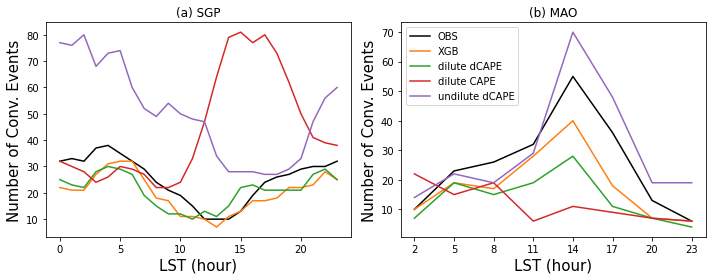

In [152]:
fig,axis = plt.subplots(1,2, figsize=(10,4), squeeze=False)


for n,site in enumerate(sites):
    diurnal = {}
    if site == 'sgp':
        for e in diurnal_list:
            diurnal[e] = np.zeros(24)
    else:
        for e in diurnal_list:
            diurnal[e] = np.zeros(8)
            
    n_sample = trigger_all[site]['XGB'].shape[0]
    
    for e in diurnal_list:
        for i in range(n_sample):
            if site == 'sgp' and trigger_all[site][e][i] == 1:
                t = i % 24
                new_t = t - 6
                if new_t < 0:
                    new_t = new_t + 24
                diurnal[e][new_t] = diurnal[e][new_t] + 1
                
            elif site == 'goamazon' and trigger_all[site][e][i] == 1:
                t = i % 8
                new_t = t - 2
                if new_t < 0:
                    new_t = new_t + 8
                diurnal[e][new_t] = diurnal[e][new_t] + 1
    
    axis[0][n].plot(diurnal['OBS'], label='OBS', color="black")
    axis[0][n].plot(diurnal['XGB'], label='XGB', color="tab:orange")
    axis[0][n].plot(diurnal['dd'], label='dilute dCAPE', color="tab:green")
    axis[0][n].plot(diurnal['dc'],label='dilute CAPE', color="tab:red")
    axis[0][n].plot(diurnal['udd'],label='undilute dCAPE', color='tab:purple')
    axis[0][1].legend()
    
    axis[0][n].tick_params(axis="x", labelsize=10)
    axis[0][n].tick_params(axis="y", labelsize=10)
    axis[0][n].set_xlabel("LST (hour)", fontsize=fh)
    axis[0][n].set_ylabel("Number of Conv. Events", fontsize=fh)
    axis[0][n].set_title(titles[n])
    
    axis[0][1].set_xticklabels(['0','2','5','8','11','14','17','20','23'])
    
plt.tight_layout()
    

            

# MLER

In [156]:
print(dataset_train_all['sgp'].columns)

Index(['LH', 'SH', 'RH_srf', 'T_srf', 'shear_low', 'shear_mid', 'shear_high',
       'T_low', 'T_mid', 'T_high', 'q_low', 'q_mid', 'q_high', 'q_adv_h_low',
       'q_adv_h_mid', 'q_adv_h_high', 's_adv_h_low', 's_adv_h_mid',
       's_adv_h_high', 'cin', 'ddcape', 'trigger'],
      dtype='object')


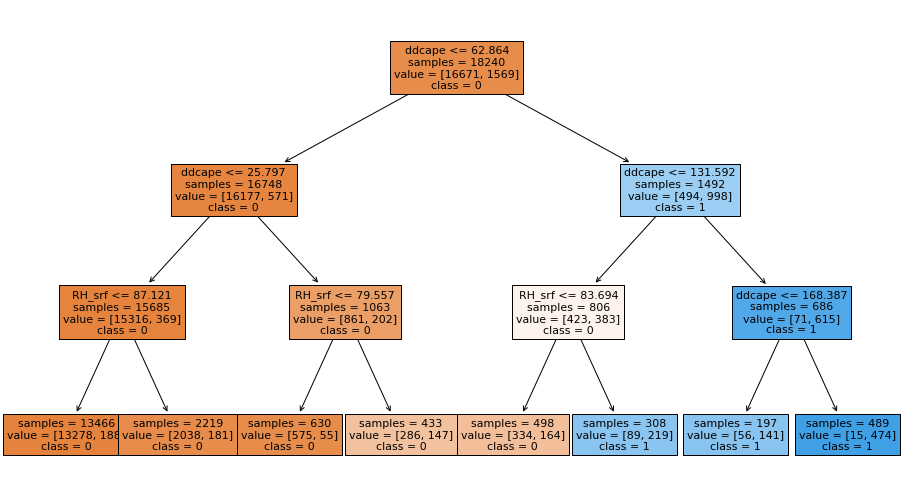

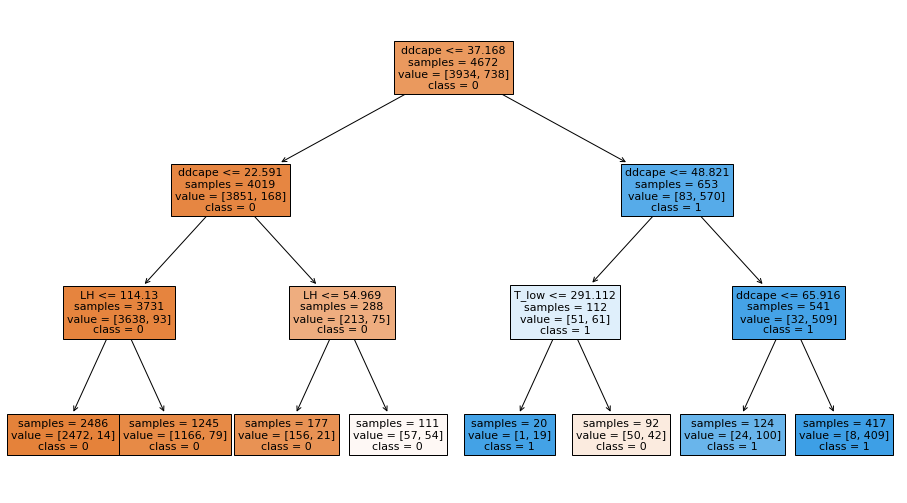

In [157]:
from sklearn import tree
for site in sites:
    if site == 'sgp':
        imp_list = ['ddcape','RH_srf','LH']
    else:
        imp_list = ['ddcape','LH','T_low']
    
    dataset_train_x = dataset_train_all[site].loc[:,imp_list]
    dataset_train_y = dataset_train_all[site].iloc[:,21]
    
    dataset_test_x = dataset_test_all[site].loc[:,imp_list]
    dataset_test_y = dataset_test_all[site].iloc[:,21]
    
    dt = tree.DecisionTreeClassifier(max_depth=3)
    dt.fit(dataset_train_x, dataset_train_y)
    
    plt.figure(figsize=(16,9))
    tree.plot_tree(dt, proportion=False, impurity=False,filled=True, feature_names=dataset_train_x.columns, label='all', fontsize=11, class_names=['0','1'])
    

# Joint

In [8]:
sgp_train_x = dataset_train_all['sgp'].iloc[:,:21]
sgp_train_y = dataset_train_all['sgp'].iloc[:,21]
sgp_test_x = dataset_test_all['sgp'].iloc[:,:21]
sgp_test_y = dataset_test_all['sgp'].iloc[:,21]

mao_train_x = dataset_train_all['goamazon'].iloc[:,:21]
mao_train_y = dataset_train_all['goamazon'].iloc[:,21]
mao_test_x = dataset_test_all['goamazon'].iloc[:,:21]
mao_test_y = dataset_test_all['goamazon'].iloc[:,21]


## SGP train, MAO test

In [10]:
xgb = XGBClassifier(n_estimators=600, nthread=20, max_depth=7,scale_pos_weight=3.5)

xgb.fit(sgp_train_x,sgp_train_y)
mao_pred_y = xgb.predict(mao_test_x)
tn, fp, fn, tp = confusion_matrix(mao_test_y, mao_pred_y).ravel()
f1 = f1_score(mao_test_y, mao_pred_y,average='macro')
P  = precision_score(mao_test_y, mao_pred_y,average='macro')
R  = recall_score(mao_test_y, mao_pred_y,average='macro')
print(tp,fp,fn,tn)
print(f1,P,R)


87 163 110 808
0.6223704172158843 0.6140871459694989 0.6368780941726306


## MAO train, SGP test

In [11]:
xgb = XGBClassifier(n_estimators=600, nthread=20, max_depth=7,scale_pos_weight=3.5)

xgb.fit(mao_train_x,mao_train_y)
sgp_pred_y = xgb.predict(sgp_test_x)
tn, fp, fn, tp = confusion_matrix(sgp_test_y, sgp_pred_y).ravel()
f1 = f1_score(sgp_test_y, sgp_pred_y,average='macro')
P  = precision_score(sgp_test_y, sgp_pred_y,average='macro')
R  = recall_score(sgp_test_y, sgp_pred_y,average='macro')
print(tp,fp,fn,tn)
print(f1,P,R)

316 312 106 3826
0.7750539918569659 0.7381132112148564 0.8367082112612498


In [12]:
dataset_all['sgp']

,LH,SH,RH_srf,T_srf,shear_low,shear_mid,shear_high,T_low,T_mid,T_high,...,q_adv_h_low,q_adv_h_mid,q_adv_h_high,s_adv_h_low,s_adv_h_mid,s_adv_h_high,cin,ddcape,trigger,prect
0,75.466141,7.962654,67.626862,26.569201,-2.53340,-0.439800,2.277530,287.479797,261.649536,227.376801,...,0.270640,0.071648,0.009683,0.236668,-0.101891,0.104103,-180.257112,118.7672,0,0.052067
1,24.207590,-0.258206,73.269478,25.152603,-2.60500,0.710010,2.058910,287.409790,261.649170,227.656403,...,0.398010,0.101111,0.010599,0.235860,-0.095660,0.156116,-158.939301,187.9128,0,0.436567
2,2.120878,1.778930,78.389183,23.797127,-2.65099,2.490150,1.903800,287.400818,261.629364,227.907013,...,0.502686,0.106643,0.007882,0.260052,-0.115239,0.182571,-144.168442,267.2368,1,0.969400
3,-2.306376,12.764638,81.118980,22.754717,-2.54720,3.758360,2.322770,287.463379,261.557800,227.999420,...,0.475903,0.076626,0.001051,0.215509,-0.275333,0.026891,-140.555413,391.7533,1,1.625967
4,-13.743360,21.948606,82.284218,21.948774,-2.37520,3.851871,3.096439,287.494995,261.392853,227.882416,...,0.331158,0.023585,-0.008498,0.184140,-0.408048,-0.180879,-139.208250,432.5973,1,1.869100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22795,381.889496,198.791901,31.840624,33.439503,-2.37587,-1.898320,-4.333591,288.095795,262.745636,229.693604,...,-0.119192,0.008844,0.001874,-0.002513,-0.030795,0.016590,-235.954147,0.0000,0,0.003207
22796,357.881775,171.816650,29.848154,33.949688,-2.56025,-2.148149,-4.648750,287.898010,262.695557,229.519196,...,-0.085071,0.006330,0.001227,-0.011819,-0.028656,0.052567,-183.360575,0.0000,0,0.015978
22797,315.306152,132.770920,28.894854,34.151997,-3.31170,-2.088310,-4.602130,287.847595,262.671753,229.572388,...,-0.053177,-0.012253,-0.002139,-0.012639,0.008640,0.162508,-152.443321,0.0000,0,0.028139
22798,257.031464,86.643425,28.789219,33.933033,-4.12932,-1.658051,-4.604079,287.860413,262.842896,229.672607,...,-0.031698,-0.037135,-0.005470,-0.011868,0.066464,0.317040,-128.243303,0.0000,0,0.025263


## Joint train, Joint test

In [16]:
joint = pd.concat([dataset_all['sgp'], dataset_all['goamazon']])
joint_x = joint.iloc[:,:21]
joint_y = joint.iloc[:,21]

joint_train_x, joint_test_x, joint_train_y, joint_test_y = train_test_split(joint_x, joint_y, test_size=0.2, random_state=20)

print(joint_train_x.shape)
print(joint_train_y.shape)
xgb = XGBClassifier(n_estimators=600, nthread=20, max_depth=7,scale_pos_weight=3.5)

xgb.fit(joint_train_x,joint_train_y)
joint_pred_y = xgb.predict(joint_test_x)
tn, fp, fn, tp = confusion_matrix(joint_test_y, joint_pred_y).ravel()
f1 = f1_score(joint_test_y, joint_pred_y,average='macro')
P  = precision_score(joint_test_y, joint_pred_y,average='macro')
R  = recall_score(joint_test_y, joint_pred_y,average='macro')
print(tp,fp,fn,tn)
print(f1,P,R)

(22912, 21)
(22912,)
464 68 122 5074
0.9058374352952495 0.9243504257178743 0.8892922237134326


## Joint train, SGP test

In [18]:
joint_train_x = np.concatenate([sgp_train_x,mao_train_x])
joint_train_y = np.concatenate([sgp_train_y,mao_train_y])

xgb.fit(joint_train_x, joint_train_y)

sgp_pred_y = xgb.predict(np.array(sgp_test_x))
tn, fp, fn, tp = confusion_matrix(sgp_test_y, sgp_pred_y).ravel()
f1 = f1_score(sgp_test_y, sgp_pred_y,average='macro')
P = precision_score(sgp_test_y, sgp_pred_y,average='macro')
R = recall_score(sgp_test_y, sgp_pred_y,average='macro')
print(tp,fp,fn,tn)
print(f1,P,R)

332 42 90 4096
0.9091565467896909 0.9331001479339075 0.8882900134918763


## Joint train, MAO test

In [19]:
joint_train_x = np.concatenate([sgp_train_x,mao_train_x])
joint_train_y = np.concatenate([sgp_train_y,mao_train_y])

xgb.fit(joint_train_x, joint_train_y)

mao_pred_y = xgb.predict(np.array(mao_test_x))
tn, fp, fn, tp = confusion_matrix(mao_test_y, mao_pred_y).ravel()
f1 = f1_score(mao_test_y, mao_pred_y,average='macro')
P = precision_score(mao_test_y, mao_pred_y,average='macro')
R = recall_score(mao_test_y, mao_pred_y,average='macro')
print(tp,fp,fn,tn)
print(f1,P,R)

166 17 31 954
0.924572166612851 0.9378158719591689 0.9125659349563744


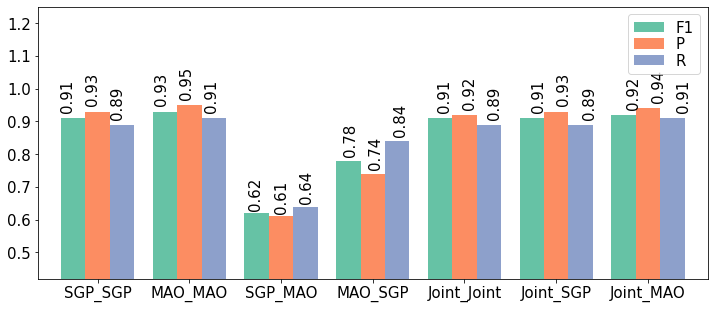

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,5))
fh = 15
perf = pd.read_excel("cmp_triggers_layer_average.xlsx", sheet_name="joint", index_col='name', engine='openpyxl')
perf = perf.dropna()

palette = plt.get_cmap('Set2')
perf.iloc[:,4:].plot.bar(ax=axes, width = .8, color=[palette(0),palette(1),palette(2)])
axes.legend(loc=1,fontsize=fh,labelspacing=0.1)
axes.set_ylim(0.42,1.25)

for p in axes.patches:
        axes.annotate(str(p.get_height()), (p.get_x() * 1.028, p.get_height() * 1.028), rotation=90, size=fh)
        
axes.tick_params(labelsize=fh)
    
plt.xlabel("")
plt.xticks(rotation=0)
plt.savefig("figs/joint.pdf")


In [20]:
a = 1373
b = 644
c = 1337
d = 26886
n = a+b+c+d

a = 42
b = 109
c = 155
d = 862
n = a+b+c+d


hss = 2*(a*d - b*c)/((a+c)*(c+d) + (a+b)*(b+d))
ets = (a-(a+b)*(a+c)/n)/(a+b+c-(a+b)*(a+c)/n)

print(a/n, b/n, c/n, d/n)
print(ets, hss)

0.03595890410958904 0.09332191780821918 0.1327054794520548 0.738013698630137
0.058929808552131625 0.11130068882035911


In [ ]:
dilute_dcape: 0.7
dilute_cape: 0.11
undilute_dcape: 0.73